In [30]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
from sklearn.exceptions import ConvergenceWarning
from sklearn import model_selection, preprocessing, metrics
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNetCV, LassoLarsCV, OrthogonalMatchingPursuitCV
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.utils import check_array
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint
import time
import xgboost as xgb
import csv
import seaborn as sns 
import pickle
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [31]:
RAW_DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/raw_data'
DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data'
TRAIN_DATA = os.path.join(RAW_DATA_PATH, 'train.csv')
TEST_DATA = os.path.join(RAW_DATA_PATH, 'test.csv')
SAMPLE_SUBMISSION = os.path.join(RAW_DATA_PATH, 'sample_submission.csv')
SUBMISSION_PATH = os.path.join(DATA_PATH, 'submissions')
MODELS_PATH = os.path.join(DATA_PATH, 'models')
ENSEMBLE_PATH = os.path.join(DATA_PATH, 'ensemble/malhotra')

In [32]:
train_df = pd.read_csv(TRAIN_DATA)
test_df = pd.read_csv(TEST_DATA)
sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION)
print('train_df.shape', train_df.shape)
print('test_df.shape', test_df.shape)

train_df.shape (4209, 378)
test_df.shape (4209, 377)


In [33]:
train_df_id_idx = train_df.set_index(['ID'], drop=True)
df = train_df_id_idx.drop(['y'], axis=1).duplicated(keep=False)
dupes_X = train_df_id_idx.drop(['y'], axis=1)[df]
dupe_ids = dupes_X.index.values
dupes = train_df_id_idx[train_df_id_idx.index.isin(dupe_ids)]
train_columns = list(set(dupes.columns) - set(['ID', 'y']))
mean_y = dupes.groupby(train_columns).y.mean().reset_index().rename(columns={'y':'mean_y'})
median_y = dupes.groupby(train_columns).y.median().reset_index().rename(columns={'y':'median_y'})
variance_y = dupes.groupby(train_columns).y.var().reset_index().rename(columns={'y':'variance_y'})
std_y = dupes.groupby(train_columns).y.std().reset_index().rename(columns={'y':'std_y'})
temp = pd.merge(dupes, mean_y, on=train_columns, how='left')
temp = pd.merge(temp, median_y, on=train_columns, how='left')
temp = pd.merge(temp, variance_y, on=train_columns, how='left')
temp = pd.merge(temp, std_y, on=train_columns, how='left')
result = temp.sort_index().sort_values(train_columns)
result['residual_y'] = result.y - result.mean_y
counts = dupes.groupby(train_columns).y.agg('count').reset_index().rename(columns={'y':'counts'})
result.head()

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X380,X382,X383,X384,X385,mean_y,median_y,variance_y,std_y,residual_y
68,101.42,ay,i,as,c,d,d,l,g,0,...,0,0,0,0,0,103.960000,103.96,12.903200,3.592102,-2.540000
80,106.50,ay,i,as,c,d,d,l,g,0,...,0,0,0,0,0,103.960000,103.96,12.903200,3.592102,2.540000
129,114.26,ay,i,as,c,d,af,j,k,0,...,0,0,0,0,0,111.836667,114.26,174.837433,13.222611,2.423333
134,123.68,ay,i,as,c,d,af,j,k,0,...,0,0,0,0,0,111.836667,114.26,174.837433,13.222611,11.843333
140,97.57,ay,i,as,c,d,af,j,k,0,...,0,0,0,0,0,111.836667,114.26,174.837433,13.222611,-14.266667


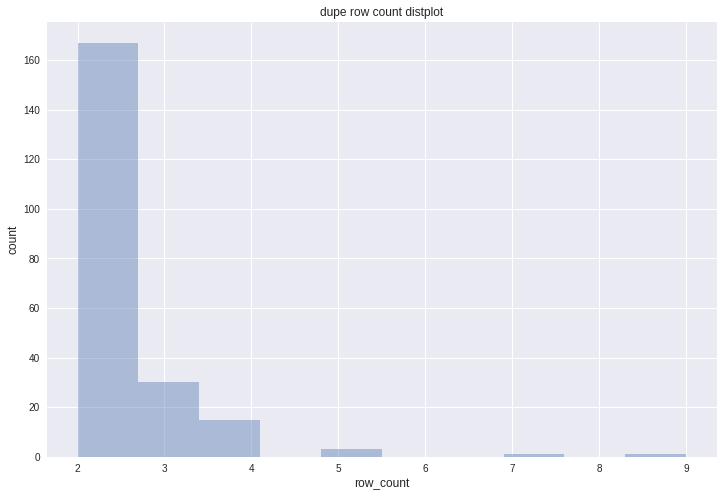

In [5]:
plt.figure(figsize=(12,8))
sns.distplot(counts.counts.values, bins=10, kde=False)
plt.xlabel('row_count', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title('dupe row count distplot')
plt.show()

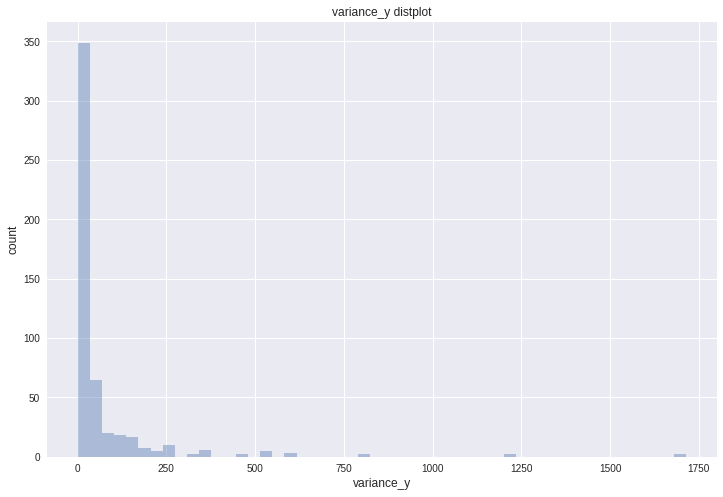

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(result.variance_y.values, bins=50, kde=False)
plt.xlabel('variance_y', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title('variance_y distplot')
plt.show()

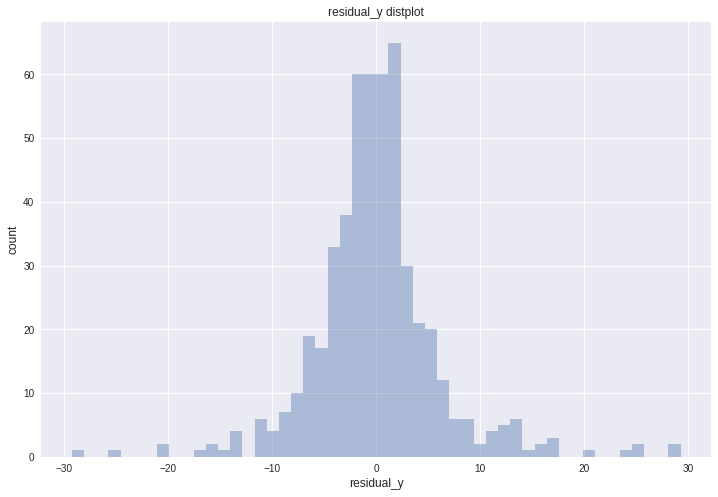

In [7]:
plt.figure(figsize=(12,8))
sns.distplot(result.residual_y.values, bins=50, kde=False)
plt.xlabel('residual_y', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title('residual_y distplot')
plt.show()

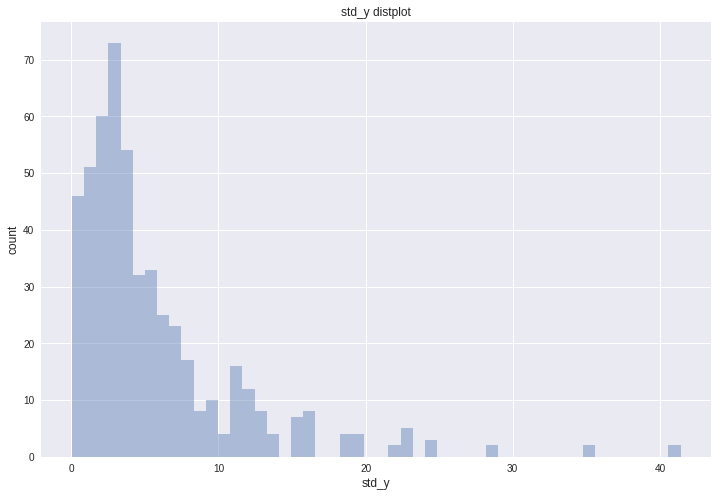

In [8]:
plt.figure(figsize=(12,8))
sns.distplot(result.std_y.values, bins=50, kde=False)
plt.xlabel('std_y', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title('std_y distplot')
plt.show()

In [34]:
filter_dupes = True
filter_outliers = True
xgb_use_augment_features = True
keep_ID = False

if filter_dupes:
    print('Filtering dupes')
    train_df = train_df[~train_df.ID.isin(dupe_ids)]

if filter_outliers:
    print('Filtering outliers')
    # Filter out outlier y = 265.32
    train_df = train_df[train_df.y < 200]
    
# Preprocess data
print('Dropping constant value columns')
for column in train_df.columns:
    cardinality = len(np.unique(train_df[column]))
    if cardinality == 1:
        train_df.drop(column, axis=1, inplace=True)
        test_df.drop(column, axis=1, inplace=True)

original_train_columns = sorted(list(set(train_df.columns) - set(['ID', 'y'])))
        
for f in ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
    lbl = preprocessing.LabelEncoder()
    train_values = set(train_df[f].values)
    test_values = set(test_df[f].values)
    all_values = list(train_values | test_values)
    lbl.fit(all_values) 
    train_df[f] = lbl.transform(list(train_df[f].values))
    test_df[f] = lbl.transform(list(test_df[f].values))

if xgb_use_augment_features:
    n_comp = 10
    
    # PCA
    pca = PCA(n_components=n_comp, random_state=420)
    pca2_results_train = pca.fit_transform(train_df.drop(["y"], axis=1))
    pca2_results_test = pca.transform(test_df)

    # ICA
    ica = FastICA(n_components=n_comp, random_state=420)
    ica2_results_train = ica.fit_transform(train_df.drop(["y"], axis=1))
    ica2_results_test = ica.transform(test_df)

    # GRP
    grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
    grp_results_train = grp.fit_transform(train_df.drop(["y"], axis=1))
    grp_results_test = grp.transform(test_df)

    # SRP
    srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
    srp_results_train = srp.fit_transform(train_df.drop(["y"], axis=1))
    srp_results_test = srp.transform(test_df)
    
    # Append decomposition components to datasets
    for i in range(0, n_comp):
        train_df['pca_' + str(i)] = pca2_results_train[:, i]
        test_df['pca_' + str(i)] = pca2_results_test[:, i]

        train_df['ica_' + str(i)] = ica2_results_train[:, i]
        test_df['ica_' + str(i)] = ica2_results_test[:, i]
        
        train_df['grp_' + str(i)] = grp_results_train[:, i]
        test_df['grp_' + str(i)] = grp_results_test[:, i]
        
        train_df['srp_' + str(i)] = srp_results_train[:, i]
        test_df['srp_' + str(i)] = srp_results_test[:, i]
        
print('train_df.shape', train_df.shape)
print('test_df.shape', test_df.shape)

Filtering dupes
Filtering outliers
Dropping constant value columns
train_df.shape (3693, 406)
test_df.shape (4209, 405)


In [37]:
if keep_ID:
    print('Keeping ID in training columns')
    X = train_df.drop(['y'], axis=1).set_index(['ID'])
    test_X = test_df.set_index(['ID'])
else:
    X = train_df.drop(["y"], axis=1).set_index(['ID'], drop=True)
    test_X = test_df.set_index(['ID'], drop=True)

Y = train_df['y'].values

print('X.shape', X.shape)
print('Y.shape', Y.shape)

X.shape (3693, 404)
Y.shape (3693,)


In [42]:
NUM_FOLDS = 5
kf = model_selection.KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
perf = []

dataset_blend_train = np.zeros((X.shape[0]))
dataset_blend_test = np.zeros((test_X.shape[0]))
dataset_blend_test_j = np.zeros((test_X.shape[0], NUM_FOLDS))

for fold, (train_idxs, val_idxs) in enumerate(kf.split(X)):
    model_id = "model-" + str(int(time.time()))
    print('Fold {} Training {}'.format(fold, model_id))
    
    trn_X, val_X = X.iloc[train_idxs], X.iloc[val_idxs]
    trn_Y, val_Y = Y[train_idxs], Y[val_idxs]
    
    mean_Y = trn_Y.mean()
    
    def xgb_r2_score(preds, dtrain):
        labels = dtrain.get_label()
        return 'rmse', -1.0 * metrics.r2_score(labels, preds)

    model = xgb.XGBRegressor(max_depth = 5,
                        objective="reg:linear",
                        n_estimators=1500,
                        learning_rate=0.0045,
                        nthread=12,
                        subsample=0.93,
                        base_score=mean_Y,
                        seed=42,
                        silent=True)

    model.fit(trn_X, trn_Y, eval_set=[(trn_X, trn_Y), (val_X, val_Y)], verbose=False, eval_metric='rmse', early_stopping_rounds=50)
    evals_result = model.evals_result()
    pickle.dump(model, open(os.path.join(MODELS_PATH, model_id + ".xgb"), "wb"))
    
    trn_Y_pred = model.predict(trn_X)
    train_r2_score = metrics.r2_score(trn_Y, trn_Y_pred)
    train_var = np.var(trn_Y_pred)
    train_mae = metrics.mean_absolute_error(trn_Y, trn_Y_pred)
    
    val_Y_pred = model.predict(val_X)
    val_r2_score = metrics.r2_score(val_Y, val_Y_pred)
    val_var = np.var(val_Y_pred)
    val_mae = metrics.mean_absolute_error(val_Y, val_Y_pred)
    
    test_Y_pred = model.predict(test_X)
    dataset_blend_train[val_idxs] = val_Y_pred
    dataset_blend_test_j[:, fold] = model.predict(test_X)
    
    perf.append((fold, model_id, train_r2_score, val_r2_score,
                 train_var, val_var,
                 train_mae, val_mae))
dataset_blend_test = dataset_blend_test_j.mean(1)

perf_df = pd.DataFrame(perf, columns=['fold', 'model_id', 'train_r2', 'validation_r2',
                                      'train_var', 'validation_var',
                                      'train_mae', 'validation_mae'])

# val_r2_mean = "{:0.5f}".format(perf_df['validation_r2'].mean())[2:]
# ts = str(int(time.time()))

# train_blend_df = pd.DataFrame(data=dataset_blend_train, index=X.index, columns=['y'])
# test_blend_df = pd.DataFrame(data=dataset_blend_test, index=test_X.index, columns=['y'])

# train_blend_df.to_csv(os.path.join(ENSEMBLE_PATH, 'malhot_xgb5fold_{}_{}_{}_train.csv'.format(ts, 0, val_r2_mean)), index=True)
# test_blend_df.to_csv(os.path.join(ENSEMBLE_PATH, 'malhot_xgb5fold_{}_{}_{}_test.csv'.format(ts, 0, val_r2_mean)), index=True)

print('Avg', '\n',
      '   train r2', perf_df['train_r2'].mean(), '\n',
      '   validation r2', perf_df['validation_r2'].mean(), '\n',
      '   train var', perf_df['train_var'].mean(), '\n',
      '   validation var', perf_df['validation_var'].mean(), '\n',
      '   train mae', perf_df['train_mae'].mean(), '\n',
      '   validation mae', perf_df['validation_mae'].mean())
print('Out of fold\n',
      '   train r2', metrics.r2_score(Y, dataset_blend_train), '\n',
      '   train mae', metrics.mean_absolute_error(Y, dataset_blend_train))
perf_df

Fold 0 Training model-1498679388
Fold 1 Training model-1498679391
Fold 2 Training model-1498679395
Fold 3 Training model-1498679398
Fold 4 Training model-1498679401
Avg 
    train r2 0.714542719596 
    validation r2 0.587751192915 
    train var 87.080241394 
    validation var 85.2125106812 
    train mae 4.52649689254 
    validation mae 5.28960051572
Out of fold
    train r2 0.588008380996 
    train mae 5.2896234663


,fold,model_id,train_r2,validation_r2,train_var,validation_var,train_mae,validation_mae
0,0,model-1498679388,0.706216,0.588988,84.287880,85.021606,4.565011,5.500670
1,1,model-1498679391,0.744103,0.581827,92.468933,83.644089,4.301981,5.259568
2,2,model-1498679395,0.690625,0.577703,83.016365,80.665962,4.739140,5.193319
3,3,model-1498679398,0.716196,0.590177,87.772949,88.470657,4.475528,5.350862
4,4,model-1498679401,0.715573,0.600062,87.855080,88.260239,4.550825,5.143583


In [47]:
# Create submission file
submission_df = test_df[['ID']]
submission_df['y'] = dataset_blend_test.tolist()
submission_df.to_csv(os.path.join(SUBMISSION_PATH, 'submission-' + str(int(time.time())) + '.csv'), index=False)
print('Generated submission ', os.path.join(SUBMISSION_PATH, 'submission-' + str(int(time.time())) + '.csv'))

Generated submission  /kaggle/dev/mercedes-benz-greener-manufacturing-data/submissions/submission-1498679476.csv


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
